In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, warnings, joblib, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# --- Load GoEmotions dataset ---
df1 = pd.read_csv("data/goemotions_1.csv")
df2 = pd.read_csv("data/goemotions_2.csv")
df3 = pd.read_csv("data/goemotions_3.csv")
df = pd.concat([df1, df2, df3], ignore_index=True)

In [6]:
# ---------------------------
# Emotion columns
# ---------------------------
emotion_columns = [
'admiration','amusement','anger','annoyance','approval','caring',
'confusion','curiosity','desire','disappointment','disapproval',
'disgust','embarrassment','excitement','fear','gratitude',
'grief','joy','love','nervousness','optimism','pride',
'realization','relief','remorse','sadness','surprise','neutral'
]


# Verify columns exist in df; some datasets name columns slightly differently
missing = [c for c in emotion_columns if c not in df.columns]
if missing:
  print('Warning - some emotion columns missing in CSVs:', missing)
  # Try to infer columns automatically (any binary columns besides metadata)
  candidate_emotions = [c for c in df.columns if df[c].dropna().isin([0,1]).all() and c not in ['id','rater_id']]
  print('Candidate binary columns detected (sample):', candidate_emotions[:10])
  # Use intersection
  emotion_columns = [c for c in emotion_columns if c in df.columns]


print('Using emotion columns:', emotion_columns)

Using emotion columns: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [8]:
business_emotion_groups = {
'Positive_Engagement': ['admiration','amusement','approval','caring','excitement','gratitude','joy','love','optimism','pride','relief'],
'Negative_Sentiment': ['anger','annoyance','disappointment','disapproval','disgust','embarrassment','fear','grief','nervousness','remorse','sadness'],
'Neutral_Interest': ['neutral','realization','surprise'],
'Active_Curiosity': ['curiosity','confusion','desire']
}



# ---------------------------
# Basic business analytics
# ---------------------------
print('\nCalculating base emotion frequencies...')
# Ensure emotion columns exist
emotion_sums = df[emotion_columns].sum()
total_labels = emotion_sums.sum()
print('Top emotions (sample):')
print(emotion_sums.sort_values(ascending=False).head(10))


Calculating base emotion frequencies...
Top emotions (sample):
neutral        55298
approval       17620
admiration     17131
annoyance      13618
gratitude      11625
disapproval    11424
curiosity       9692
amusement       9245
realization     8785
optimism        8715
dtype: int64


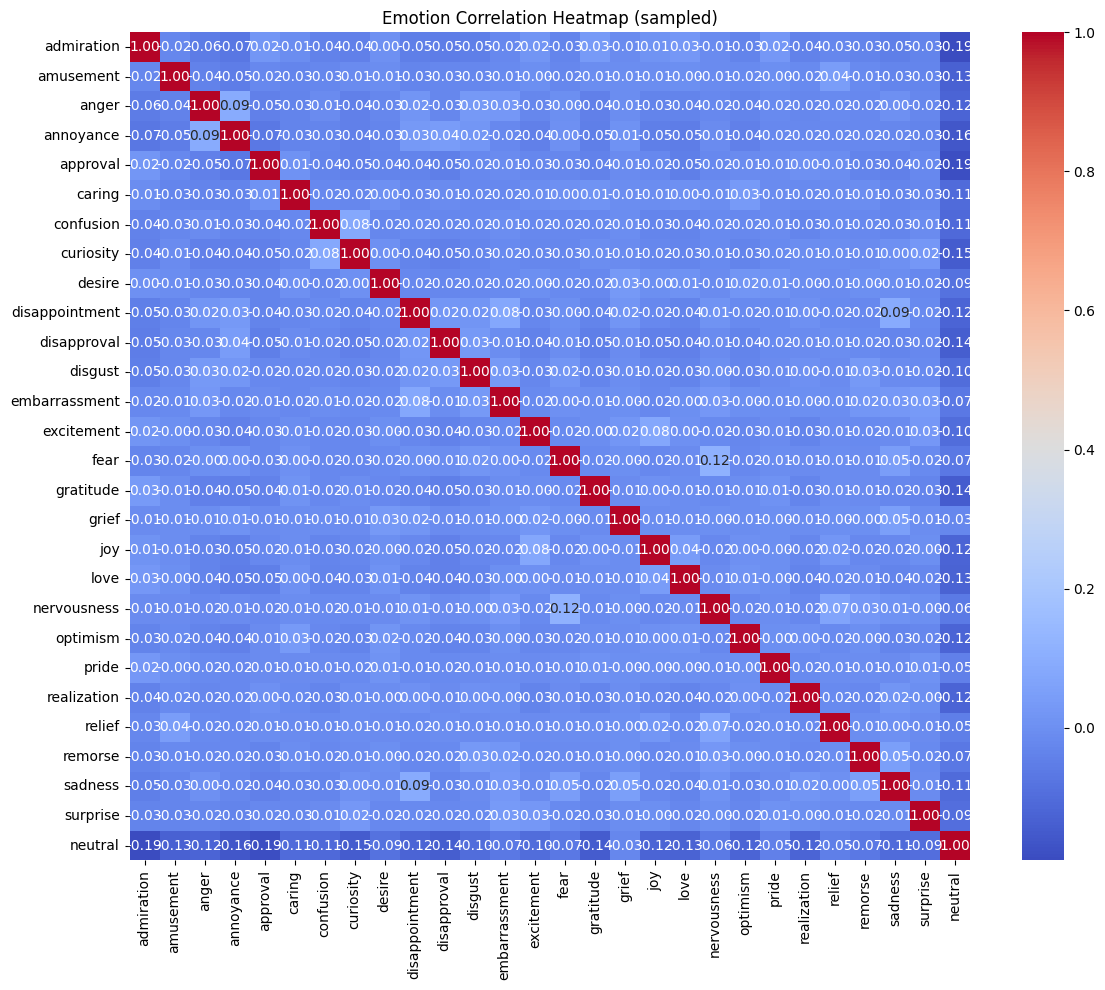

In [10]:
# If emotion_sums is a pandas Series of total counts per emotion
# Create a "fake" DataFrame with normalized percentages per emotion
emo_df = pd.DataFrame({e: df[e].sample(n=5000, random_state=42) for e in emotion_sums.index})  # sample 5k rows
plt.figure(figsize=(12, 10))
sns.heatmap(emo_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Emotion Correlation Heatmap (sampled)')
plt.tight_layout()
plt.show()


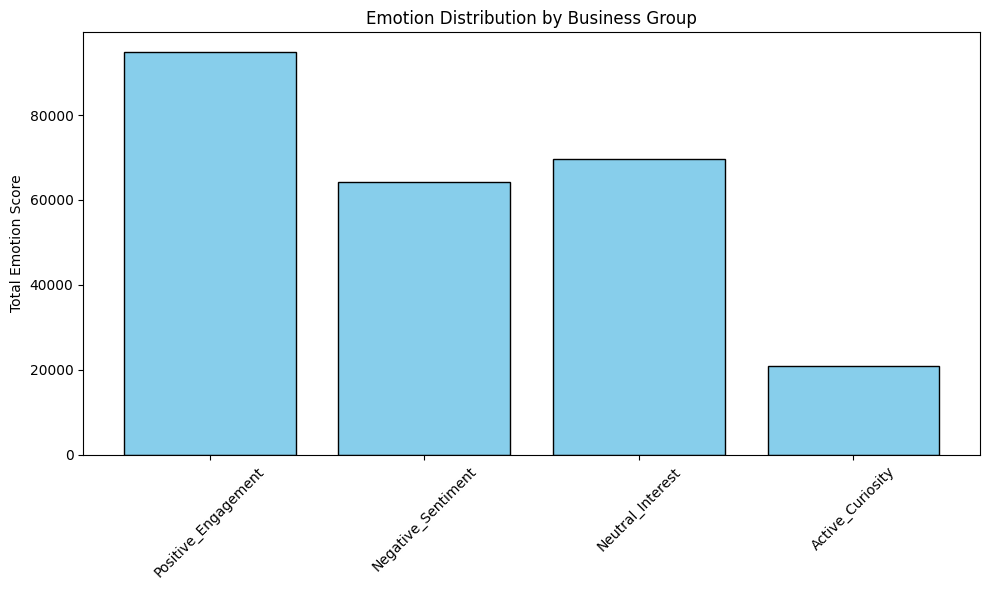

In [11]:
group_scores = {g: float(np.sum([emotion_sums[e] for e in emos if e in emotion_sums])) 
                for g, emos in business_emotion_groups.items()}

plt.figure(figsize=(10, 6))
plt.bar(group_scores.keys(), group_scores.values(), color='skyblue', edgecolor='black')
plt.xticks(rotation=45)
plt.ylabel('Total Emotion Score')
plt.title('Emotion Distribution by Business Group')
plt.tight_layout()
plt.show()


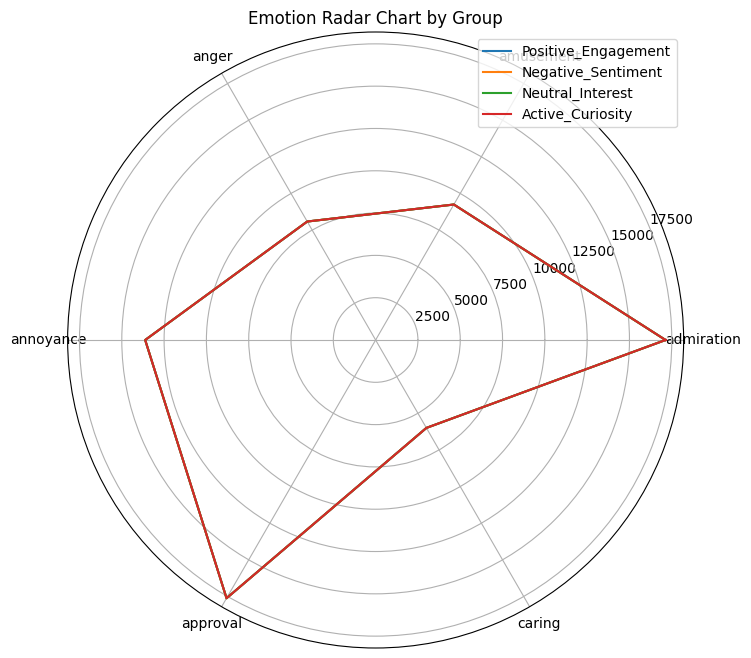

In [16]:
import matplotlib.pyplot as plt
import numpy as np

groups = list(group_scores.keys())
emotions = list(emotion_sums.index)[:6]  # top 6 emotions for clarity

angles = np.linspace(0, 2*np.pi, len(emotions), endpoint=False).tolist()
angles += angles[:1]  # complete the loop

plt.figure(figsize=(8,8))
for g in groups:
    values = [emotion_sums[e] if e in emotion_sums else 0 for e in emotions]
    values += values[:1]
    plt.polar(angles, values, label=g)

plt.xticks(angles[:-1], emotions)
plt.title('Emotion Radar Chart by Group')
plt.legend()
plt.show()



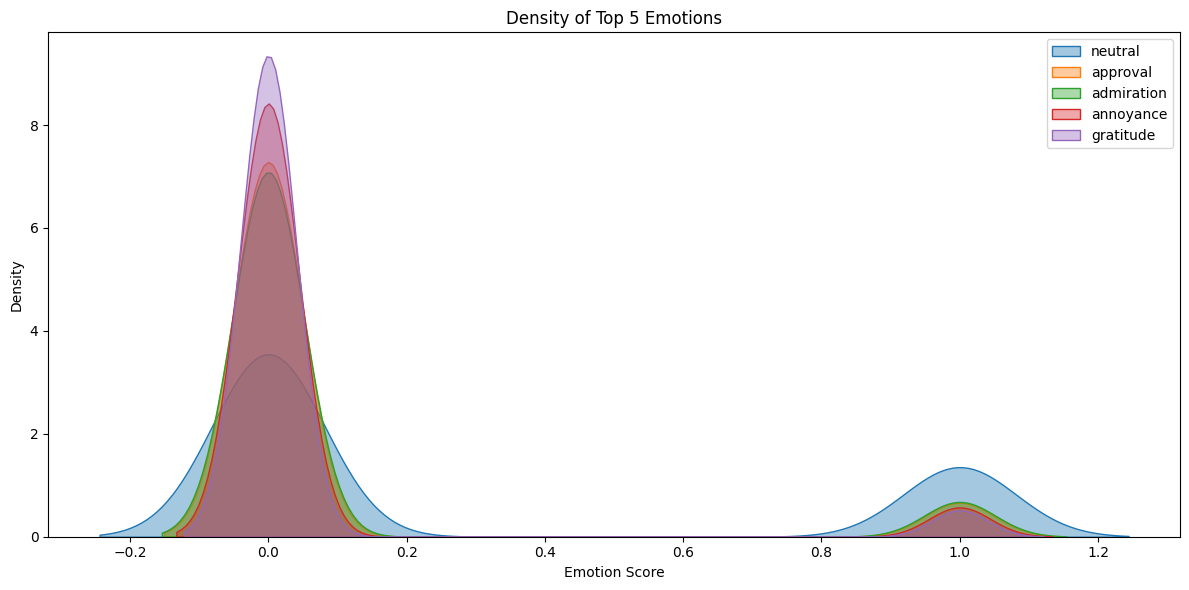

In [18]:
sampled_df = df[emotion_sums.index].sample(5000, random_state=42)

plt.figure(figsize=(12,6))
for emo in emotion_sums.sort_values(ascending=False).head(5).index:
    sns.kdeplot(sampled_df[emo], label=emo, fill=True, alpha=0.4)

plt.title('Density of Top 5 Emotions')
plt.xlabel('Emotion Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# ---------------------------
# Text preprocessing
# ---------------------------
print('\nPreprocessing text...')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


url_re = re.compile(r'http\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
nonalpha_re = re.compile(r'[^a-zA-Z\s]')


Preprocessing text...


In [10]:
def clean_text(text):
    if pd.isna(text):
        return ''

    text = str(text).lower()
    text = url_re.sub(' ', text)        # remove URLs
    text = mention_re.sub(' ', text)    # remove mentions
    text = nonalpha_re.sub(' ', text)   # remove non-alphanumeric
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(t)
        for t in tokens
        if t not in stop_words and len(t) > 2
    ]
    return ' '.join(tokens)


In [11]:
df['clean_text'] = df['text'].astype(str).apply(clean_text)
print(df['clean_text'].head(10))

0                                            game hurt
1    sexuality grouping category make different oth...
2                                      right care fuck
3                                      man love reddit
4                             name nowhere near falcon
5    right considering important document know damn...
6    big still quite popular heard thing content ne...
7    crazy went super religion high school think re...
8                                         adorable asf
9      sponge blurb pub quaw haha gurr aaa finale real
Name: clean_text, dtype: object


In [12]:
# ---------------------------
X = df['clean_text']
y = df[emotion_columns].astype(int)
# If y has no columns because of missing, raise
if y.shape[1] == 0:
  raise ValueError('No emotion label columns available after preprocessing. Check CSV columns.')


# ---------------------------
# Train/test split
# ---------------------------
print('\nSplitting dataset...')
# Stratify is tricky for multilabel; use simple split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])


# ---------------------------
# Feature extraction (TF-IDF)
# ---------------------------
print('\nVectorizing text with TF-IDF...')
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print('TF-IDF shapes:', X_train_tfidf.shape, X_test_tfidf.shape)


Splitting dataset...
Train samples: 168980 Test samples: 42245

Vectorizing text with TF-IDF...
TF-IDF shapes: (168980, 10000) (42245, 10000)


In [14]:
# ---------------------------
# Feature extraction (TF-IDF)
# ---------------------------
print('\nVectorizing text with TF-IDF...')
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print('TF-IDF shapes:', X_train_tfidf.shape, X_test_tfidf.shape)


# # ---------------------------
# # Model training
# # ---------------------------
# print('\nTraining models (this can take a few minutes)...')
# # Logistic Regression (fast)
# lr_clf = MultiOutputClassifier(LogisticRegression(max_iter=1000))
# lr_clf.fit(X_train_tfidf, y_train)


Vectorizing text with TF-IDF...
TF-IDF shapes: (168980, 10000) (42245, 10000)


In [15]:
# ---------------------------
# Model training (Optimized)
# ---------------------------
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

print("\nTraining Logistic Regression (optimized for text data)...")

# Logistic Regression (scalable + fast on sparse TF-IDF)
lr_clf = MultiOutputClassifier(
    LogisticRegression(
        max_iter=1000,
        solver="saga",   # better for large datasets
        n_jobs=-1,       # parallelize across cores
        C=1.0            # regularization strength (tune if needed)
    )
)

# Fit only on TF-IDF features
lr_clf.fit(X_train_tfidf, y_train)

# Save trained model and vectorizer
joblib.dump(lr_clf, "lr_model.joblib")
joblib.dump(vectorizer, "vectorizer.joblib")

print("✅ Logistic Regression model saved as lr_model.joblib")
print("✅ TF-IDF vectorizer saved as vectorizer.joblib")



Training Logistic Regression (optimized for text data)...
✅ Logistic Regression model saved as lr_model.joblib
✅ TF-IDF vectorizer saved as vectorizer.joblib


In [16]:
import joblib
import numpy as np

def predict_emotion_business(texts, model_choice='lr'):
    """
    Predict emotions and business group scores for input text(s).
    Automatically loads the trained model and vectorizer from disk.

    Args:
        texts (str or list[str]): Input text(s) to analyze.
        model_choice (str): 'lr' for Logistic Regression, 'rf' for Random Forest.

    Returns:
        dict or list[dict]: Predictions with emotion probabilities and business group scores.
    """
    # Handle single string vs list
    if isinstance(texts, str):
        texts = [texts]

    # Load vectorizer
    vectorizer = joblib.load("vectorizer.joblib")

    model = joblib.load("lr_model.joblib")

    # Transform input text
    X_tfidf = vectorizer.transform([clean_text(t) for t in texts])
    probs = model.predict_proba(X_tfidf)  # list of arrays (one per label)

    results = []
    for s_idx, text in enumerate(texts):
        emotion_probs = {}
        for i, emo in enumerate(emotion_columns):
            arr = probs[i]  # shape: (n_samples, 2)
            if arr.shape[1] == 2:
                p = arr[s_idx, 1]  # probability of positive class
            else:
                p = arr[s_idx, 0]
            emotion_probs[emo] = float(p)

        # Aggregate into business groups
        business_scores = {}
        for grp, emos in business_emotion_groups.items():
            vals = [emotion_probs[e] for e in emos if e in emotion_probs]
            business_scores[grp] = float(np.mean(vals)) if vals else 0.0

        results.append({
            "text": text,
            "emotion_probs": emotion_probs,
            "business_scores": business_scores
        })

    return results if len(results) > 1 else results[0]



Preparing basic visualizations...


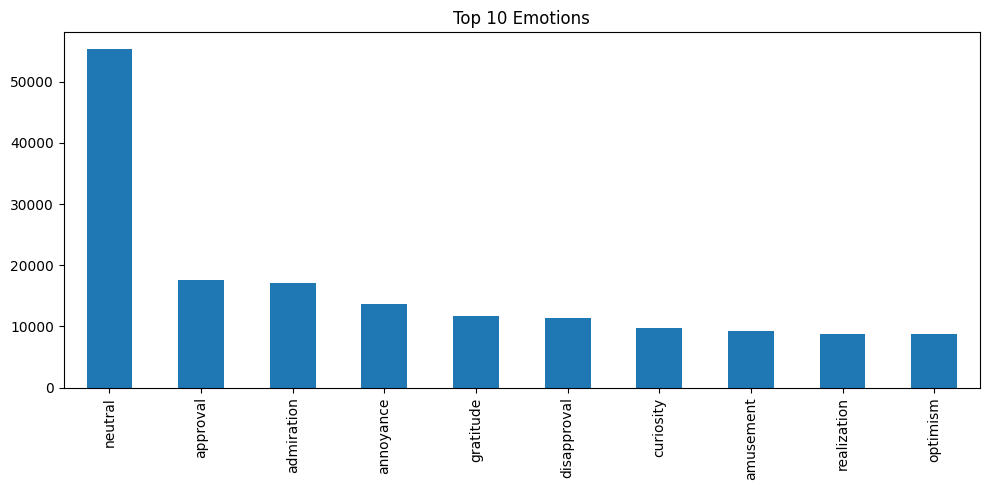

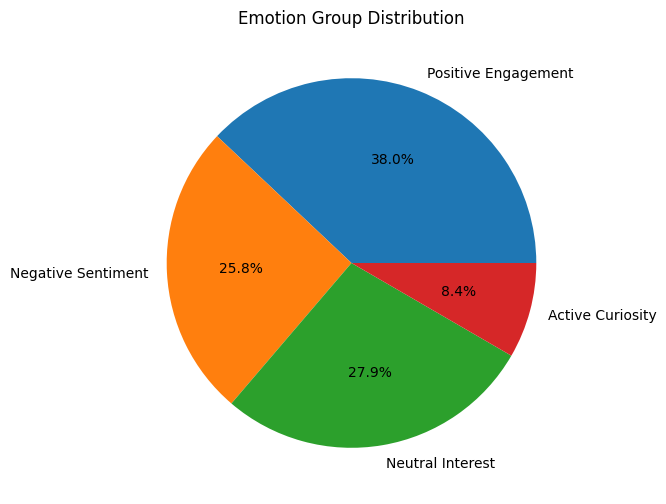


Test predictions on sample business texts:

Text: I absolutely love this new jacket, it's gorgeous!
Top 3 emotions: [('love', 0.663), ('admiration', 0.424), ('approval', 0.089)]
Business group scores: {'Positive_Engagement': 0.122, 'Negative_Sentiment': 0.008, 'Neutral_Interest': 0.016, 'Active_Curiosity': 0.015}

Text: The fabric feels cheap and I'm disappointed.
Top 3 emotions: [('disappointment', 0.577), ('neutral', 0.101), ('approval', 0.09)]
Business group scores: {'Positive_Engagement': 0.025, 'Negative_Sentiment': 0.074, 'Neutral_Interest': 0.057, 'Active_Curiosity': 0.021}

Text: Hmm, this design is interesting, not sure if I like it yet.
Top 3 emotions: [('approval', 0.185), ('confusion', 0.169), ('excitement', 0.15)]
Business group scores: {'Positive_Engagement': 0.056, 'Negative_Sentiment': 0.008, 'Neutral_Interest': 0.064, 'Active_Curiosity': 0.107}

Text: This is okay, nothing special but it works.
Top 3 emotions: [('neutral', 0.276), ('approval', 0.181), ('caring', 0.128

In [19]:
# ---------------------------
# Visualization helpers
# ---------------------------
print('\nPreparing basic visualizations...')

# Top 10 emotions in dataset
plt.figure(figsize=(10, 5))
emo_counts = emotion_sums.sort_values(ascending=False)
emo_counts.head(10).plot(kind='bar', title='Top 10 Emotions')
plt.tight_layout()
plt.show()

# Business groups pie
group_scores = {}
for g, emos in business_emotion_groups.items():
    vals = [emotion_sums[e] for e in emos if e in emotion_sums]
    group_scores[g] = float(np.sum(vals))

plt.figure(figsize=(6, 6))
plt.pie(
    list(group_scores.values()),
    labels=[g.replace('_', ' ') for g in group_scores.keys()],
    autopct='%1.1f%%'
)
plt.title('Emotion Group Distribution')
plt.show()

# ---------------------------
# Quick interactive test examples
# ---------------------------
print('\nTest predictions on sample business texts:')
examples = [
    "I absolutely love this new jacket, it's gorgeous!",
    "The fabric feels cheap and I'm disappointed.",
    "Hmm, this design is interesting, not sure if I like it yet.",
    "This is okay, nothing special but it works."
]

for ex in examples:
    out = predict_emotion_business(ex, model_choice='rf')

    # ensure we always work with a dict (single text case)
    if isinstance(out, list):
        out = out[0]

    top3 = sorted(out['emotion_probs'].items(), key=lambda x: x[1], reverse=True)[:3]
    print('\nText:', ex)
    print('Top 3 emotions:', [(k, round(v, 3)) for k, v in top3])
    print('Business group scores:', {k: round(v, 3) for k, v in out['business_scores'].items()})

print('\nModel training complete. Use predict_emotion_business(text) to analyze new comments.')


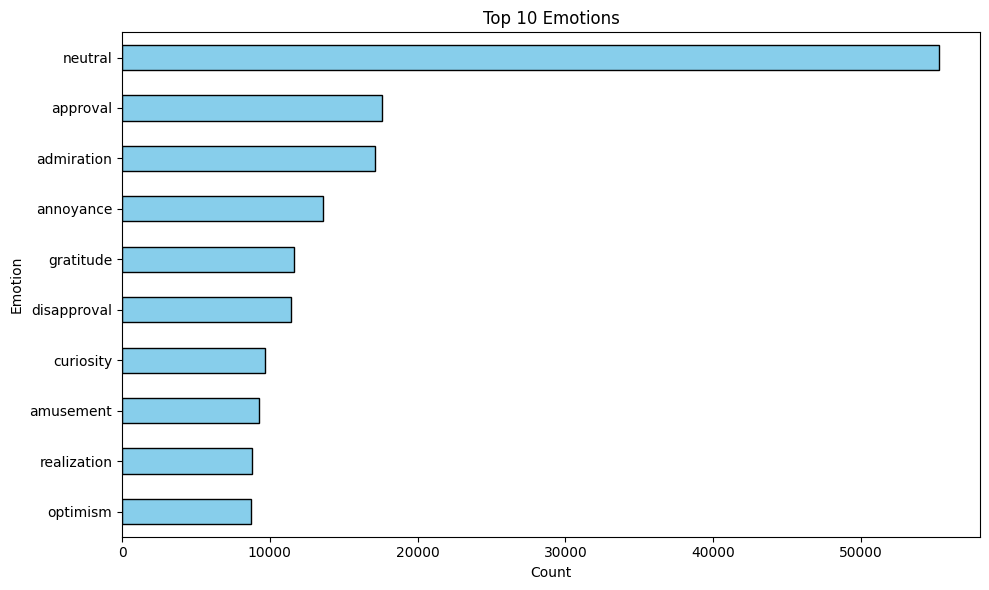

In [21]:
plt.figure(figsize=(10, 6))
emo_counts.head(10).sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Emotions')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined